In [2]:
import scipy
from scipy.spatial.distance import squareform
import cellgrid
from initialization import init_uniform
import numpy as np
from MDAnalysis.lib.distances import self_distance_array
import itertools

In [3]:
%load_ext memory_profiler
%matplotlib inline

In [4]:
def _check_box(box):
    if box.shape == (6,):
        box1 = box[:3]
    else:
        box1 = box
    return box1

def pair_contact(cg,maxdist):
    indx,dist = cellgrid.capped_self_distance_array(cg._coordinates,maxdist,cg._box)
    mask = np.where(dist<maxdist)
    return indx[mask],dist[mask]

In [5]:
def bf_select(box, points, maxdist):
    distance = self_distance_array(points,box)
    distance = scipy.spatial.distance.squareform(distance)
    distance[np.tril_indices(distance.shape[0])] += (1.1*maxdist)
    mask = np.where((distance < maxdist))
    out = (np.column_stack((mask[0],mask[1])),distance[mask])
    return out

In [6]:
def cg_select(box,cellsize,points,cutoff_distance):
    box = _check_box(box)
    cellsize = max(cellsize,cutoff_distance)
    cg1 = cellgrid.CellGrid(box,cellsize,points)
    out_cg = pair_contact(cg1,cutoff_distance)
    return out_cg

def cg_build(box,cellsize,points,cutoff_distance):
    box = _check_box(box)
    cellsize = max(cellsize,cutoff_distance)
    cg1 = cellgrid.CellGrid(box,cellsize,points)
    return cg1

def cg_select_old(box, points, maxdist):
    box = _check_box(box)
    indx,dist = cellgrid.capped_self_distance_array(points,maxdist,box)
    mask = np.where(dist<maxdist)
    return indx[mask],dist[mask]


# Cellsize > Cutoff_Distance

In [16]:
##Setting
box = np.array([100,100,100,90.,90.,90.],dtype=np.float32)
cellsize = 10.
cutoff_distance = 5.
Npoints = 1000

In [17]:
#Initialization
points = init_uniform(box,Npoints)

In [18]:
out_cg = cg_select(box,cellsize,points,cutoff_distance)

In [19]:
out_bf = bf_select(box,points,cutoff_distance)

In [20]:
out_cgold = cg_select_old(box,points,cutoff_distance)

In [21]:
out_cgold

(array([[306,  73],
        [114, 983],
        [402, 137],
        [689, 101],
        [163, 132],
        [479, 103],
        [479, 595],
        [479, 863],
        [103, 595],
        [103, 426],
        [595, 426],
        [444, 287],
        [706, 211],
        [895, 498],
        [903,  73],
        [621, 768],
        [726, 889],
        [246, 277],
        [246, 393],
        [364, 692],
        [ 14, 671],
        [615, 668],
        [524, 287],
        [524, 444],
        [231, 259],
        [525, 361],
        [749, 572],
        [749, 768],
        [572,  35],
        [204, 143],
        [658, 933],
        [305,  10],
        [ 10, 436],
        [312, 463],
        [312, 189],
        [463, 189],
        [312, 296],
        [282, 124],
        [489, 143],
        [767, 987],
        [ 58, 278],
        [ 58, 815],
        [278, 815],
        [814, 717],
        [504, 544],
        [376, 334],
        [468, 477],
        [711, 816],
        [781, 645],
        [987, 854],


# Testing

In [26]:
# Length
np.testing.assert_equal(out_bf[1].shape,out_cg[1].shape)
np.testing.assert_equal(out_bf[1].shape,out_cgold[1].shape)
# Distances
np.testing.assert_array_almost_equal(np.sort(out_bf[1].astype(np.float64)),np.sort(out_cg[1]),decimal=5) #Comparing array values
np.testing.assert_array_almost_equal(np.sort(out_bf[1].astype(np.float64)),np.sort(out_cgold[1]),decimal=5)
# Indices
np.testing.assert_array_equal(np.unique(out_cg[0]),np.unique(out_bf[0]))
np.testing.assert_array_equal(np.unique(out_cgold[0]),np.unique(out_bf[0]))

# Variation of cellsize with Npoints and cutoff distance

In [225]:
#Setting
cellsize = np.linspace(5,30,num=6,dtype=np.int32)
Npoints = np.logspace(2,4.5,num=10,dtype=np.int32)
cutoff = np.linspace(5,30,num=6,dtype=np.float64)
box = np.array([100,100,100,90.,90.,90.],dtype=np.float32)

In [141]:
cellsize,Npoints,cutoff

(array([ 5, 10, 15, 20, 25, 30], dtype=int32),
 array([  100,   189,   359,   681,  1291,  2448,  4641,  8799, 16681,
        31622], dtype=int32),
 array([ 5., 10., 15., 20., 25., 30.]))

In [142]:
data,old = [],[]
for npt in Npoints:
    points = init_uniform(box,npt)
    print("Npoints : {}".format(npt))
    for cut in cutoff:
        time_build_old = %timeit -q -o -n 2 -r 3 cellgrid.CellGrid(_check_box(box),cut,points)
        time_old = %timeit -q -o -n 2 -r 3 cg_select_old(box,points,cut)
        old.append((npt,cut,time_build_old.average,time_old.average))
        print("Cutoff : {}".format(cut))
        for cs in cellsize:
            time_build = %timeit -q -o -n 2 -r 3 cg_build(_check_box(box),cs,points,cut)
            time = %timeit -q -o -n 2 -r 3 cg_select(box,cs,points,cut)
            print("Cellsize : {}".format(cs))
            #print("Npoints {} CellSize {} Time {}".format(npt,cs,time.average))
            data.append((npt,cs,cut,time.average,time_build.average))

Npoints : 100
Cutoff : 5.0
Cellsize : 5
Cellsize : 10
Cellsize : 15
Cellsize : 20
Cellsize : 25
Cellsize : 30
Cutoff : 10.0
Cellsize : 5
Cellsize : 10
Cellsize : 15
Cellsize : 20
Cellsize : 25
Cellsize : 30
Cutoff : 15.0
Cellsize : 5
Cellsize : 10
Cellsize : 15
Cellsize : 20
Cellsize : 25
Cellsize : 30
Cutoff : 20.0
Cellsize : 5
Cellsize : 10
Cellsize : 15
Cellsize : 20
Cellsize : 25
Cellsize : 30
Cutoff : 25.0
Cellsize : 5
Cellsize : 10
Cellsize : 15
Cellsize : 20
Cellsize : 25
Cellsize : 30
Cutoff : 30.0
Cellsize : 5
Cellsize : 10
Cellsize : 15
Cellsize : 20
Cellsize : 25
Cellsize : 30
Npoints : 189
Cutoff : 5.0
Cellsize : 5
Cellsize : 10
Cellsize : 15
Cellsize : 20
Cellsize : 25
Cellsize : 30
Cutoff : 10.0
Cellsize : 5
Cellsize : 10
Cellsize : 15
Cellsize : 20
Cellsize : 25
Cellsize : 30
Cutoff : 15.0
Cellsize : 5
Cellsize : 10
Cellsize : 15
Cellsize : 20
Cellsize : 25
Cellsize : 30
Cutoff : 20.0
Cellsize : 5
Cellsize : 10
Cellsize : 15
Cellsize : 20
Cellsize : 25
Cellsize : 30
Cuto

KeyboardInterrupt: 

In [155]:
old,data

([(100, 5.0, 0.028836833334935363, 0.8932566666650624),
  (100, 10.0, 0.0031120000009347373, 0.1412878333358094),
  (100, 15.0, 0.0010243333308608271, 0.034840333331279304),
  (100, 20.0, 0.0011338333327633638, 0.026346500000120916),
  (100, 25.0, 0.0005296666640788317, 0.017376166666508652),
  (100, 30.0, 0.0004086666643464317, 0.006897500003105961),
  (189, 5.0, 0.024432499999723706, 0.9279650000001615),
  (189, 10.0, 0.003228166669335527, 0.14017716666906685),
  (189, 15.0, 0.0012373333350600053, 0.04430850000062492),
  (189, 20.0, 0.0011000000013154931, 0.030730000003435027),
  (189, 25.0, 0.0006911666666079933, 0.01822149999740456),
  (189, 30.0, 0.0005354999981742973, 0.007985666665869454),
  (359, 5.0, 0.026787666669406462, 0.9432686666671847),
  (359, 10.0, 0.0037093333351852684, 0.15936599999986356),
  (359, 15.0, 0.0017056666668698501, 0.05290283333548965),
  (359, 20.0, 0.0012299999992440764, 0.031604499999957625),
  (359, 25.0, 0.0012616666693550844, 0.01773733333538985),
 

# Visualization

In [44]:
import matplotlib
import matplotlib.pyplot as plt

In [156]:
data

array([[1.00000000e+02, 5.00000000e+00, 5.00000000e+00, 9.31638833e-01,
        2.30253333e-02],
       [1.00000000e+02, 1.00000000e+01, 5.00000000e+00, 8.82333500e-01,
        4.12733333e-03],
       [1.00000000e+02, 1.50000000e+01, 5.00000000e+00, 8.81645667e-01,
        1.19150000e-03],
       ...,
       [3.16220000e+04, 1.50000000e+01, 2.50000000e+01, 1.36046412e+01,
        7.57115000e-02],
       [3.16220000e+04, 2.00000000e+01, 2.50000000e+01, 1.28788490e+01,
        1.16153500e-01],
       [3.16220000e+04, 2.50000000e+01, 2.50000000e+01, 1.27281608e+01,
        8.16263333e-02]])

## Fixed Cutoff Distance and variation with Cellsize

[[1.00000000e+02 5.00000000e+00 1.00000000e+01 1.32297833e-01
  3.04883333e-03]
 [1.89000000e+02 5.00000000e+00 1.00000000e+01 1.42510500e-01
  3.40916667e-03]
 [3.59000000e+02 5.00000000e+00 1.00000000e+01 1.64870000e-01
  3.87483333e-03]
 [6.81000000e+02 5.00000000e+00 1.00000000e+01 1.96736167e-01
  4.81716667e-03]
 [1.29100000e+03 5.00000000e+00 1.00000000e+01 2.23174333e-01
  6.39333333e-03]
 [2.44800000e+03 5.00000000e+00 1.00000000e+01 2.61273000e-01
  8.90966667e-03]
 [4.64100000e+03 5.00000000e+00 1.00000000e+01 3.04905167e-01
  1.87175000e-02]
 [8.79900000e+03 5.00000000e+00 1.00000000e+01 3.12520000e-01
  2.23203333e-02]
 [1.66810000e+04 5.00000000e+00 1.00000000e+01 3.88836667e-01
  4.04381667e-02]
 [3.16220000e+04 5.00000000e+00 1.00000000e+01 8.74831333e-01
  7.62028333e-02]]


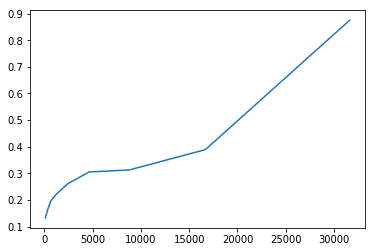

In [168]:
mask = np.where(data[...,2] == 10.)
#print(data[mask])
mask2 = np.where(data[mask][...,1]==5)
print(data[mask][mask2])
plt.plot(Npoints,data[mask][mask2][...,3])

In [175]:
old = np.array(old)

In [197]:
old,data

(array([[1.00000000e+02, 5.00000000e+00, 2.88368333e-02, 8.93256667e-01],
        [1.00000000e+02, 1.00000000e+01, 3.11200000e-03, 1.41287833e-01],
        [1.00000000e+02, 1.50000000e+01, 1.02433333e-03, 3.48403333e-02],
        [1.00000000e+02, 2.00000000e+01, 1.13383333e-03, 2.63465000e-02],
        [1.00000000e+02, 2.50000000e+01, 5.29666664e-04, 1.73761667e-02],
        [1.00000000e+02, 3.00000000e+01, 4.08666664e-04, 6.89750000e-03],
        [1.89000000e+02, 5.00000000e+00, 2.44325000e-02, 9.27965000e-01],
        [1.89000000e+02, 1.00000000e+01, 3.22816667e-03, 1.40177167e-01],
        [1.89000000e+02, 1.50000000e+01, 1.23733334e-03, 4.43085000e-02],
        [1.89000000e+02, 2.00000000e+01, 1.10000000e-03, 3.07300000e-02],
        [1.89000000e+02, 2.50000000e+01, 6.91166667e-04, 1.82215000e-02],
        [1.89000000e+02, 3.00000000e+01, 5.35499998e-04, 7.98566667e-03],
        [3.59000000e+02, 5.00000000e+00, 2.67876667e-02, 9.43268667e-01],
        [3.59000000e+02, 1.00000000e+0

In [205]:
mask = np.where(old[:,1]==10)
old[mask][:,3]

array([0.14128783, 0.14017717, 0.159366  , 0.18614267, 0.21748417,
       0.2546975 , 0.2919945 , 0.29282983, 0.351265  , 0.81634633])

In [207]:
c = 20
cut = 25 
mask = np.where(data[:,2]==cut)
mask_cs = np.where(data[mask][:,1]==c)
time = data[mask][mask_cs][:,3]
print(time)

[ 0.01722083  0.01682033  0.0187685   0.02065383  0.02650967  0.04476133
  0.18396133  0.5877495   2.3896135  12.878849  ]


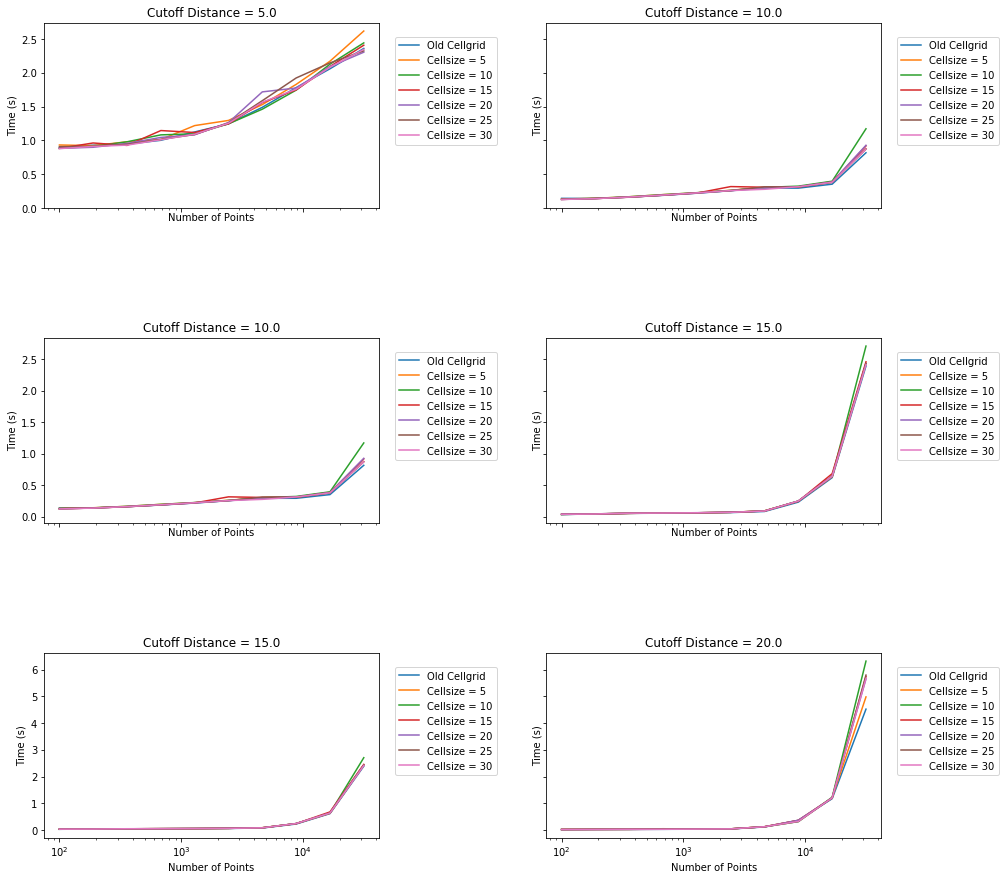

In [183]:
data,old = np.array(data),np.array(old)
col,row = 2,len(cutoff)//2
fig, (ax) = plt.subplots(row, col, sharex='col', sharey='row')
fig.subplots_adjust(hspace=0.7, wspace=0.5)
fig.set_size_inches(15,15)
#ax = np.array([ax])
for c in range(col):
    for r in range(row):
        mask = np.where(data[...,2] == cutoff[r+c])
        time_old = old[np.where(old[:,1] == cutoff[r+c])][:,3]
        ax[r,c].plot(Npoints,time_old,label="Old Cellgrid")
        for cs in cellsize:
            #time = np.empty()
            mask_cs = np.where(data[mask][...,1] == cs)
            time = data[mask][mask_cs][:,3]
            #print(Npoints,time)
            ax[r,c].plot(Npoints,time,label="Cellsize = {}".format(cs))
            ax[r,c].legend(loc='upper center', bbox_to_anchor=(1.2, 0.95),ncol=1, fancybox=True)
            ax[r,c].set_xlabel('Number of Points')
            ax[r,c].set_ylabel('Time (s)')
            ax[r,c].set_xscale('log')
        ax[r,c].set_title('Cutoff Distance = {}'.format(cutoff[r+c]))

## Variation of cellsize with time for diifferent cutoff distances


In [253]:
data,old = np.array(data),np.array(old)
npt = Npoints[-1]
cs_arr = cellsize 
cs_arr

array([ 5, 10, 15, 20, 25, 30], dtype=int32)

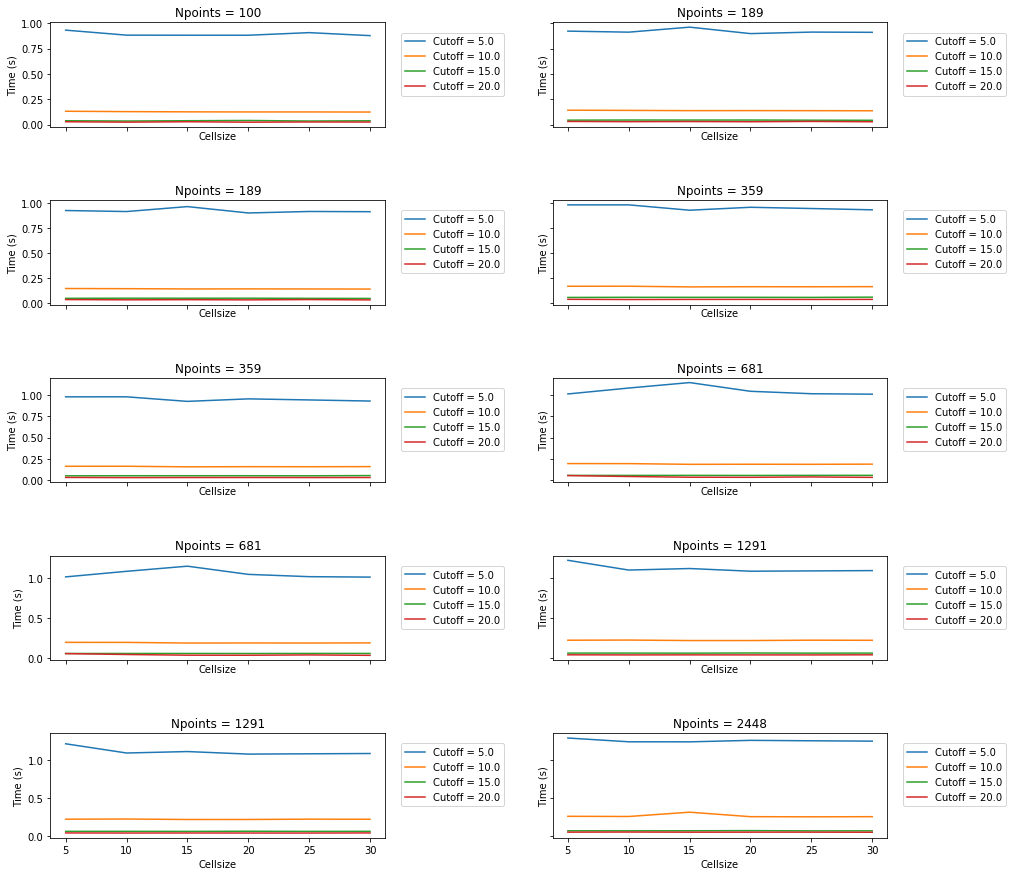

In [259]:
col,row = 2,len(Npoints)//2
fig, (ax) = plt.subplots(row, col, sharex='col', sharey='row')
fig.subplots_adjust(hspace=0.7, wspace=0.5)
fig.set_size_inches(15,15)
for c in range(col):
    for r in range(row):
        npt = Npoints[r+c]
        for cut in cutoff[:-2]:
            m = data[(data[:,0]==npt) & (data[:,2]==cut)]
            time = m[:,3]
            ax[r,c].plot(cs_arr,time,label="Cutoff = {}".format(cut))
            ax[r,c].legend(loc='upper center', bbox_to_anchor=(1.2, 0.95),ncol=1, fancybox=True)
            ax[r,c].set_xlabel('Cellsize')
            ax[r,c].set_ylabel('Time (s)')
            ax[r,c].autoscale()
            #ax[r,c].set_xscale('log')
        ax[r,c].set_title('Npoints = {}'.format(npt))